# Applied ML For Engineering Assignment - B-cell epitope prediction using supervised ML

## Config

In [85]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_classif, mutual_info_classif
from sklearn.metrics import average_precision_score, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit, ParameterGrid, StratifiedGroupKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from imblearn.base import BaseSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings("ignore")

RANDOM_STATE = 8
np.random.seed(RANDOM_STATE)

## Data loading

In [86]:
DATA_PATH = "5693_trypanosoma_cruzi.csv"

df = pd.read_csv(DATA_PATH, sep=";", engine="python")

TARGET_COL = "Class"
GROUP_COL = "Info_group"

feature_cols = [column for column in df.columns if column.startswith("feat_")]

X = df[feature_cols].values
y_raw = df[TARGET_COL].values
# Convert to binary classification (1 = positive class, 0 = negative)
y = (y_raw == 1).astype(int)

# Groups are used to prevent data leakage in CV (samples from the same group stay together)
groups = df[GROUP_COL].values

print("X shape:", X.shape)
print("y distribution:", np.bincount(y))
print("groups shape:", groups.shape)

# Remove features that are constant across all samples (zero variance)
# These features provide no information for classification
# threshold=0.0 removes only exactly-constant columns
vt = VarianceThreshold(threshold=0.0)
X = vt.fit_transform(X)
print("After VarianceThreshold, X shape:", X.shape)


X shape: (2588, 1635)
y distribution: [2069  519]
groups shape: (2588,)
After VarianceThreshold, X shape: (2588, 1635)


## Data Exploration

In [87]:
# EDA variables point to full dataset
X_eda = X
y_eda = y
groups_eda = groups
df_eda = df.copy()

print(f"EDA Configuration:")
print(f"- Using full dataset for EDA (all groups)")
print(f"- Total samples: {len(X_eda):,}")
print(f"- Total groups: {len(np.unique(groups_eda)):,}")
print(f"- Positive samples: {y_eda.sum():,} ({y_eda.sum()/len(y_eda)*100:.1f}%)")

EDA Configuration:
- Using full dataset for EDA (all groups)
- Total samples: 2,588
- Total groups: 15
- Positive samples: 519 (20.1%)


### Target and Group Distribution

Analysis of class balance and group size distribution to understand the dataset structure.

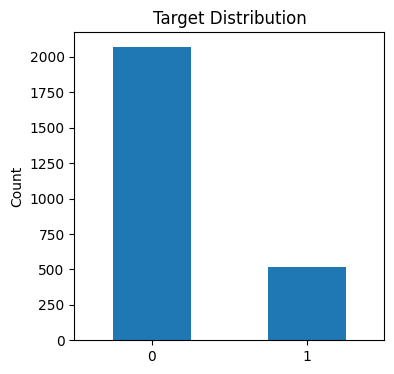

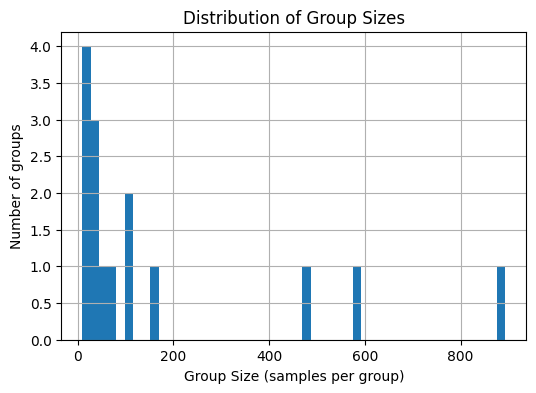


Top 10 largest groups (by number of samples):


,Group ID,Number of Samples
1,25,893
2,77,577
3,63,471
4,349,152
5,381,105
6,22,99
7,35,65
8,138,51
9,339,37
10,376,35


In [88]:
# Class distribution
plt.figure(figsize=(4, 4))
pd.Series(y).value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

# Group size distribution
group_sizes = pd.Series(groups).value_counts()
plt.figure(figsize=(6, 4))
group_sizes.hist(bins=50)
plt.title("Distribution of Group Sizes")
plt.xlabel("Group Size (samples per group)")
plt.ylabel("Number of groups")
plt.show()

print("\nTop 10 largest groups (by number of samples):")
top_groups_df = pd.DataFrame({
    'Group ID': group_sizes.head(10).index,
    'Number of Samples': group_sizes.head(10).values
}).reset_index(drop=True)
top_groups_df.index = top_groups_df.index + 1
display(top_groups_df)

### Feature Variance

Identify low-variance features that provide minimal information for classification.

In [89]:
variances = df[feature_cols].var().sort_values()

print("Low-variance features (variance < 1e-5):")
low_var_features = variances[variances < 1e-5]
if len(low_var_features) > 0:
    low_var_df = pd.DataFrame({
        'Feature': low_var_features.index,
        'Variance': low_var_features.values
    }).reset_index(drop=True)
    low_var_df.index = low_var_df.index + 1
    display(low_var_df)
else:
    print("No features with variance < 1e-5 found.")

Low-variance features (variance < 1e-5):


,Feature,Variance
1,feat_QSO_Grantham.Xr.W,9.572217e-11
2,feat_QSO_Grantham.Xr.C,1.293210e-10
3,feat_QSO_Grantham.Xr.Y,2.931200e-10
4,feat_QSO_Grantham.Xr.M,3.310982e-10
5,feat_QSO_Grantham.Xr.H,3.499204e-10
6,feat_QSO_Grantham.Xr.I,3.955636e-10
7,feat_QSO_Grantham.Xr.N,5.557827e-10
8,feat_QSO_Grantham.Xr.F,6.470600e-10
9,feat_QSO_Grantham.Xr.Q,6.616066e-10
10,feat_QSO_Grantham.Xr.R,6.994785e-10


### Feature Correlation Heatmap

Visualize correlations among the top 50 highest-variance features to identify redundant patterns.

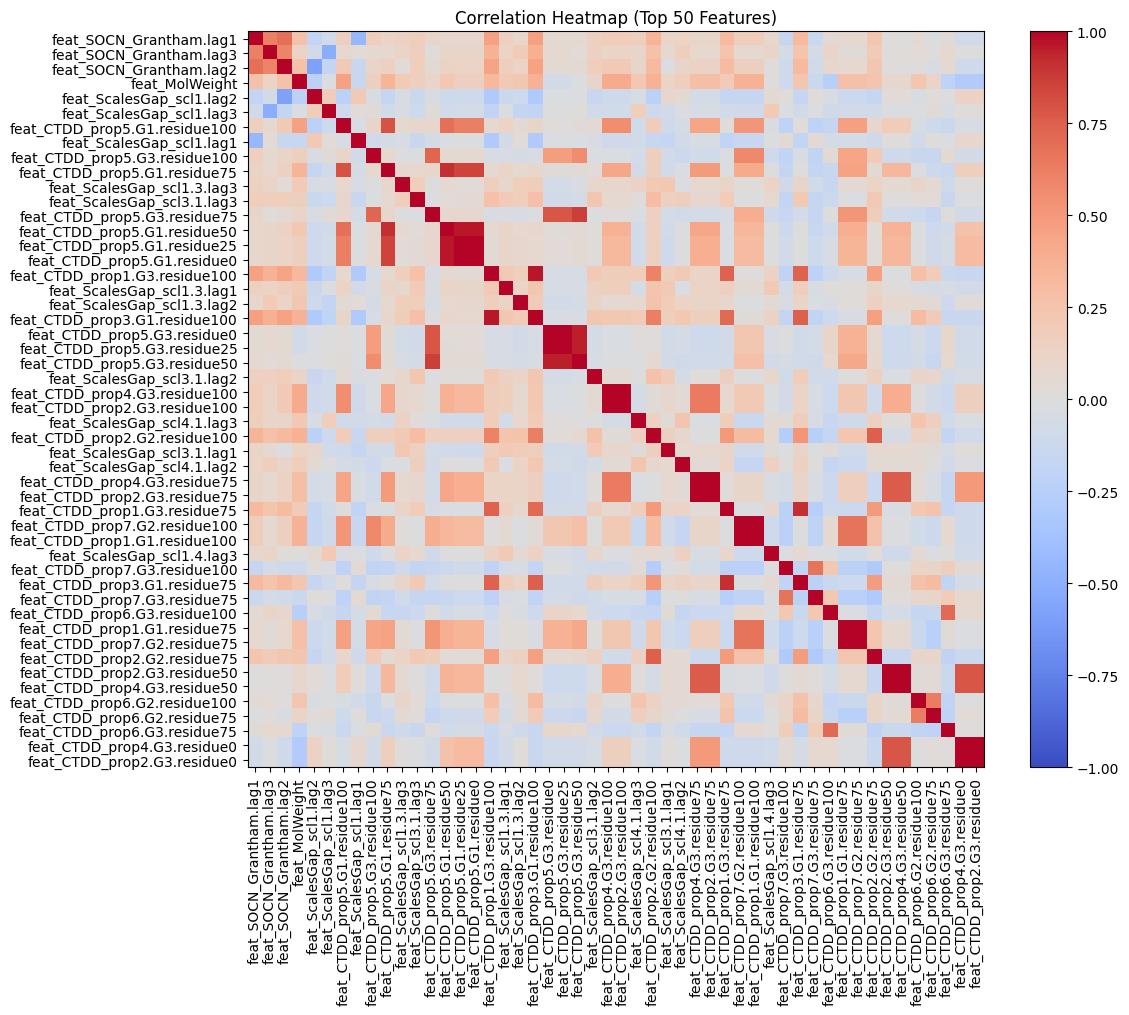

In [90]:
# Select top 50 features by variance
top50 = variances.sort_values(ascending=False).head(50).index

corr = df[top50].corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Correlation Heatmap (Top 50 Features)")
plt.xticks(range(len(top50)), top50, rotation=90)
plt.yticks(range(len(top50)), top50)
plt.tight_layout()
plt.show()

### Mutual Information with Target

Compute mutual information scores to identify which features are most predictive of the target variable.

In [91]:
# GROUP-AWARE: Calculate MI within each group and average across groups
# This prevents group structure from biasing MI estimates
X_full_eda = df_eda[feature_cols].values.astype(np.float32)

unique_groups_eda = np.unique(groups_eda)
avg_mi = np.zeros(len(feature_cols))

for group_id in unique_groups_eda:
    group_mask = (groups_eda == group_id)
    X_group = X_full_eda[group_mask]
    y_group = y_eda[group_mask]
    
    # Only calculate MI if group has both classes and multiple samples
    if len(np.unique(y_group)) > 1 and len(y_group) > 1:
        group_mi = mutual_info_classif(X_group, y_group, random_state=RANDOM_STATE)
        avg_mi += group_mi

# Average across groups
avg_mi /= len(unique_groups_eda)
mi_series = pd.Series(avg_mi, index=feature_cols).sort_values(ascending=False)

print(f"Calculated MI averaged across {len(unique_groups_eda)} groups")

# Top 20 features
print("\nTop 20 features by Mutual Information (group-aware):")
top_mi_df = pd.DataFrame({
    'Feature': mi_series.head(20).index,
    'Mutual Information': mi_series.head(20).values
}).reset_index(drop=True)
top_mi_df.index = top_mi_df.index + 1
display(top_mi_df)

# Bottom 20 features
print("\nBottom 20 features by Mutual Information (group-aware):")
bottom_mi_df = pd.DataFrame({
    'Feature': mi_series.tail(20).index,
    'Mutual Information': mi_series.tail(20).values
}).reset_index(drop=True)
bottom_mi_df.index = bottom_mi_df.index + 1
display(bottom_mi_df)

Calculated MI averaged across 15 groups

Top 20 features by Mutual Information (group-aware):


,Feature,Mutual Information
1,feat_ScalesGap_scl3.lag1,0.138588
2,feat_ScalesGap_scl5.3.lag3,0.134939
3,feat_ScalesGap_scl3.1.lag1,0.123409
4,feat_ScalesGap_scl2.lag1,0.122522
5,feat_ScalesGap_scl3.5.lag2,0.122399
6,feat_QSO_Grantham.Xr.D,0.121631
7,feat_ScalesGap_scl3.2.lag1,0.121035
8,feat_ScalesGap_scl2.4.lag3,0.119793
9,feat_QSO_Schneider.Xr.L,0.118365
10,feat_Atoms_nN,0.118154



Bottom 20 features by Mutual Information (group-aware):


,Feature,Mutual Information
1,feat_esm2_813,0.002178
2,feat_esm2_573,0.002076
3,feat_esm2_853,0.002063
4,feat_esm2_179,0.002014
5,feat_esm2_626,0.001992
6,feat_esm2_168,0.001976
7,feat_esm2_114,0.001930
8,feat_esm2_581,0.001912
9,feat_CTDD_prop2.G2.residue100,0.001604
10,feat_CTDD_prop4.G2.residue100,0.001441


### PCA Projection

2D visualization of the feature space to assess class separability and data structure.

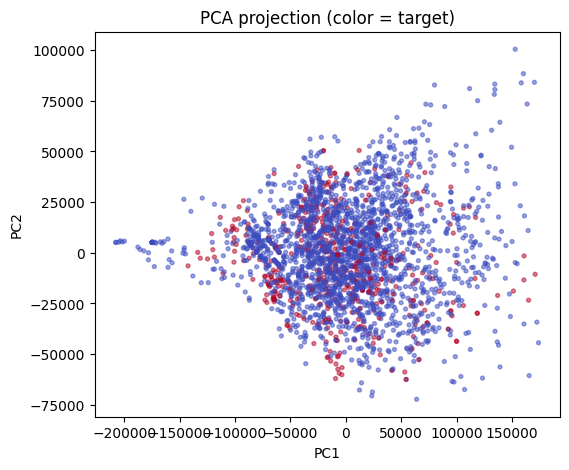

Explained variance ratio (PC1, PC2): [0.75618113 0.13637003]


In [92]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", s=8, alpha=0.5)
plt.title("PCA projection (color = target)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

### Highly Correlated Feature Pairs

Identify feature pairs with correlation > 0.95 to detect redundancy in the dataset.

In [93]:
# GROUP-AWARE: Calculate correlation within each group and average across groups
# This prevents group structure from inflating correlation estimates

X_full_eda = df_eda[feature_cols].values
unique_groups_eda = np.unique(groups_eda)
avg_corr_matrix = np.zeros((len(feature_cols), len(feature_cols)))

for group_id in unique_groups_eda:
    group_mask = (groups_eda == group_id)
    X_group = X_full_eda[group_mask]
    
    # Only calculate correlation if group has multiple samples
    if len(X_group) > 1:
        group_corr = pd.DataFrame(X_group, columns=feature_cols).corr().abs().values
        # Replace NaN with 0 (happens when feature is constant in this group)
        group_corr = np.nan_to_num(group_corr, nan=0.0)
        avg_corr_matrix += group_corr

# Average across groups
avg_corr_matrix /= len(unique_groups_eda)
corr_matrix = pd.DataFrame(avg_corr_matrix, index=feature_cols, columns=feature_cols)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

print(f"Calculated correlations averaged across {len(unique_groups_eda)} groups")

high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i + 1, len(feature_cols)):
        val = upper.iloc[i, j]
        if val > 0.95:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.index[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': val
            })

print(f"\nHighly correlated feature pairs (|corr| > 0.95, group-aware):")
print(f"Total pairs found: {len(high_corr_pairs)}")

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(f"\nShowing top 20 pairs:")
    display(high_corr_df.head(20))
else:
    print("No highly correlated pairs found.")

Calculated correlations averaged across 15 groups

Highly correlated feature pairs (|corr| > 0.95, group-aware):
Total pairs found: 22

Showing top 20 pairs:

Highly correlated feature pairs (|corr| > 0.95, group-aware):
Total pairs found: 22

Showing top 20 pairs:


,Feature 1,Feature 2,Correlation
0,feat_AAtypes_NonPolar,feat_AAtypes_Polar,1.000000
1,feat_CTDD_prop1.G1.residue0,feat_CTDD_prop7.G2.residue0,1.000000
2,feat_CTDD_prop1.G1.residue25,feat_CTDD_prop7.G2.residue25,1.000000
3,feat_CTDD_prop1.G1.residue50,feat_CTDD_prop7.G2.residue50,1.000000
5,feat_CTDD_prop1.G1.residue75,feat_CTDD_prop7.G2.residue75,1.000000
7,feat_CTDD_prop1.G1.residue100,feat_CTDD_prop7.G2.residue100,1.000000
15,feat_CTDD_prop2.G3.residue75,feat_CTDD_prop4.G3.residue75,1.000000
10,feat_CTDD_prop2.G3.residue0,feat_CTDD_prop4.G3.residue0,1.000000
13,feat_CTDD_prop2.G3.residue25,feat_CTDD_prop4.G3.residue25,1.000000
14,feat_CTDD_prop2.G3.residue50,feat_CTDD_prop4.G3.residue50,1.000000


### Feature Distributions

Visualize distributions of top features to understand data characteristics.

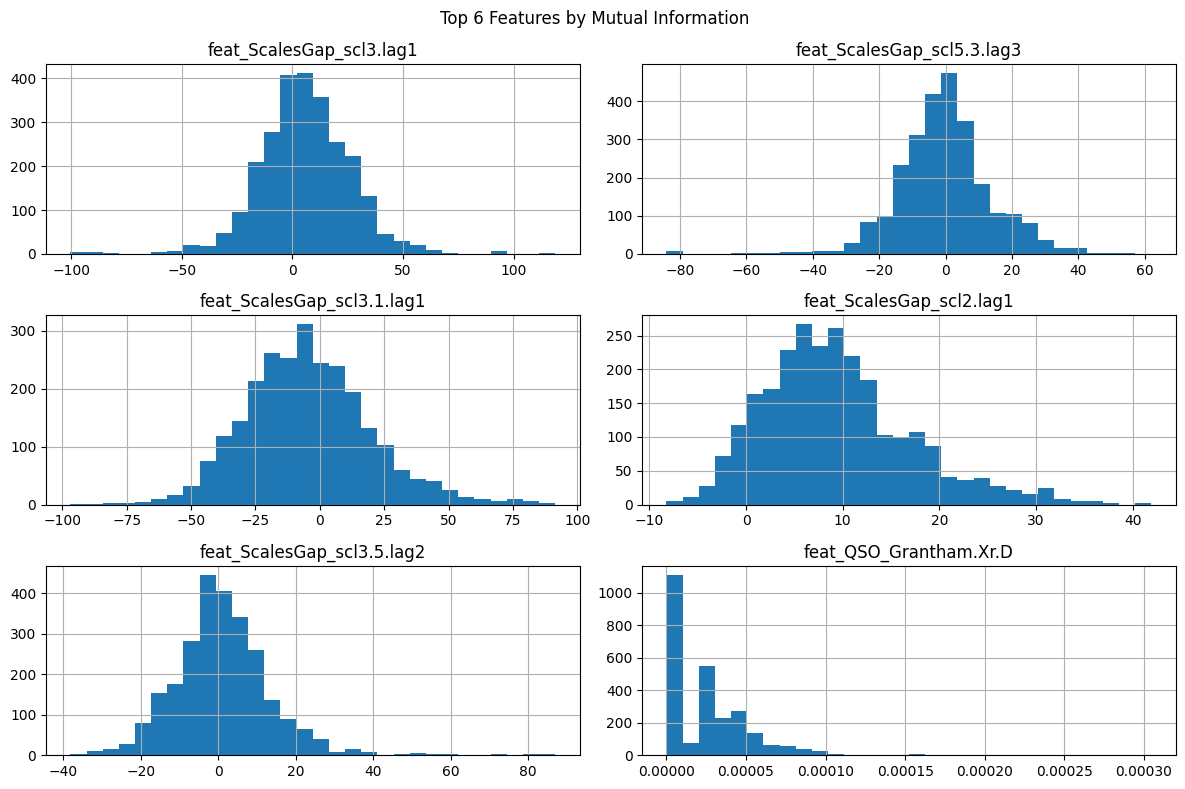

In [94]:
top6_features = mi_series.head(6).index.tolist()

df[top6_features].hist(figsize=(12, 8), bins=30)
plt.suptitle("Top 6 Features by Mutual Information")
plt.tight_layout()
plt.show()

## Feature Reduction

Reduce dimensionality by removing redundant and uninformative features:

1. **Remove highly correlated features** (|correlation| > 0.95)
2. **Remove low mutual information features** (bottom 10th percentile)

This conservative approach removes clear redundancy while preserving signal for model training.

In [95]:
# Step 1: Remove highly correlated features (GROUP-AWARE)

X_full = df[feature_cols].values
unique_groups = np.unique(groups)

# Calculate average correlation across groups
avg_corr_matrix = np.zeros((len(feature_cols), len(feature_cols)))

for group_id in unique_groups:
    group_mask = (groups == group_id)
    X_group = X_full[group_mask]
    
    # Only calculate correlation if group has multiple samples
    if len(X_group) > 1:
        group_corr = pd.DataFrame(X_group, columns=feature_cols).corr().abs().values
        # Replace NaN with 0 (happens when feature is constant in this group)
        group_corr = np.nan_to_num(group_corr, nan=0.0)
        avg_corr_matrix += group_corr

# Average across groups
avg_corr_matrix /= len(unique_groups)
avg_corr_df = pd.DataFrame(avg_corr_matrix, index=feature_cols, columns=feature_cols)
upper_avg = avg_corr_df.where(np.triu(np.ones(avg_corr_df.shape), k=1).astype(bool))

# Find features to drop (keep first, drop second in each pair)
features_to_drop_corr = set()
for i in range(len(feature_cols)):
    for j in range(i + 1, len(feature_cols)):
        if upper_avg.iloc[i, j] > 0.95:
            features_to_drop_corr.add(feature_cols[j])

# Step 2: Calculate mutual information per group and average (GROUP-AWARE)
avg_mi = np.zeros(len(feature_cols))

for group_id in unique_groups:
    group_mask = (groups == group_id)
    X_group = X_full[group_mask]
    y_group = y[group_mask]
    
    # Only calculate MI if group has both classes (otherwise MI is undefined)
    if len(np.unique(y_group)) > 1 and len(y_group) > 1:
        group_mi = mutual_info_classif(X_group, y_group, random_state=RANDOM_STATE)
        avg_mi += group_mi

# Average across groups
avg_mi /= len(unique_groups)
mi_series_full = pd.Series(avg_mi, index=feature_cols)

# Set threshold: remove features with MI in bottom 10%
mi_threshold = np.percentile(avg_mi, 10)
features_to_drop_mi = set(mi_series_full[mi_series_full < mi_threshold].index)

# Combine both removal strategies
features_to_drop_total = features_to_drop_corr.union(features_to_drop_mi)
features_to_keep = [f for f in feature_cols if f not in features_to_drop_total]

print("\n" + "=" * 80)
print("COMBINED FEATURE REDUCTION SUMMARY (GROUP-AWARE)")
print("=" * 80)
print(f"Original features: {len(feature_cols)}")
print(f"Features removed (high corr): {len(features_to_drop_corr)}")
print(f"Features removed (low MI): {len(features_to_drop_mi)}")
print(f"Features removed (overlap): {len(features_to_drop_corr.intersection(features_to_drop_mi))}")
print(f"Total features removed: {len(features_to_drop_total)}")
print(f"Features remaining: {len(features_to_keep)}")
print(f"Reduction: {len(features_to_drop_total)/len(feature_cols)*100:.1f}%")

# Apply feature reduction to X
X_reduced = df[features_to_keep].values

# Apply VarianceThreshold to the reduced set
vt_reduced = VarianceThreshold(threshold=0.0)
X_final = vt_reduced.fit_transform(X_reduced)

print(f"\nAfter VarianceThreshold on reduced set: {X_final.shape[1]} features")
print(f"Total reduction: {len(feature_cols)} -> {X_final.shape[1]} features ({(1 - X_final.shape[1]/len(feature_cols))*100:.1f}% reduction)")

# Update X for model training
X = X_final
print(f"\nUpdated X shape for model training: {X.shape}")


COMBINED FEATURE REDUCTION SUMMARY (GROUP-AWARE)
Original features: 1635
Features removed (high corr): 17
Features removed (low MI): 164
Features removed (overlap): 6
Total features removed: 175
Features remaining: 1460
Reduction: 10.7%

After VarianceThreshold on reduced set: 1460 features
Total reduction: 1635 -> 1460 features (10.7% reduction)

Updated X shape for model training: (2588, 1460)


## Model Training

### Split Data

In [96]:
# Split data into train and test sets while respecting group boundaries
# Samples from the same group must stay together to prevent data leakage
# If we split within groups, the model could "memorize" group-specific patterns and overestimate performance
# GroupShuffleSplit ensures no group appears in both train and test sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class distribution:", np.bincount(y_train) / len(y_train))
print("Test class distribution:", np.bincount(y_test) / len(y_test))

# Define cross-validation strategy for hyperparameter tuning
# StratifiedGroupKFold maintains class proportions and respects groups in each fold
# This prevents leakage while ensuring each fold is representative of the class imbalance
cv = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE,
)

Train shape: (1640, 1460)  Test shape: (948, 1460)
Train class distribution: [0.7445122 0.2554878]
Test class distribution: [0.89451477 0.10548523]


### Pipeline Components

In [97]:
# Custom identity sampler to allow "no sampling" option in the pipeline
# imblearn requires all resampling steps to inherit from BaseSampler
class IdentitySampler(BaseSampler):
    """Imblearn-style sampler that leaves X, y unchanged."""
    def __init__(self):
        super().__init__()

    def _fit_resample(self, X, y):
        return X, y


# Define resampling strategies to test
# I include "none" to compare against baseline (no resampling)
samplers = {
    "none": IdentitySampler(),
    "smote": SMOTE(random_state=RANDOM_STATE),
    "under": RandomUnderSampler(random_state=RANDOM_STATE),
}

# Define scaling strategies
# Random Forest doesn't need scaling, but MLP does
scalers = {
    "none": FunctionTransformer(validate=False),
    "standard": StandardScaler(),
}

# Define dimensionality reduction strategies
# Test both feature selection (SelectPercentile) and transformation (PCA)
reducers = {
    "none": FunctionTransformer(validate=False),
    "univ20": SelectPercentile(score_func=f_classif, percentile=20),
    "pca20": PCA(n_components=20, random_state=RANDOM_STATE),
}

# Define classifiers to test
# Random Forest: ensemble method, handles non-linearity, robust to scaling
# MLP: neural network, can learn complex patterns, requires scaling
classifiers = {
    "rf": RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1, # Use all available cores
    ),
    "mlp": MLPClassifier(
        activation="relu",
        max_iter=300,
        early_stopping=True, # Stop training when validation score stops improving
        n_iter_no_change=10, # Wait 10 epochs before stopping
        validation_fraction=0.1, # Use 10% of training data for early stopping validation
        random_state=RANDOM_STATE,
    ),
}

### Classifier Specific Pipeline Search Space

In [98]:
def make_base_pipeline(clf_name: str) -> ImbPipeline:
    """
    Create a base ImbPipeline for a given classifier.
    Pipeline has four steps: scaler, reducer, sampler, clf
    
    Note: ImbPipeline is used instead of sklearn Pipeline because it properly handles
    resampling operations (SMOTE, undersampling) which need to be applied after splitting
    but before the final classifier.
    """
    pipe = ImbPipeline(
        steps=[
            ("scaler",  scalers["standard"]),
            ("reducer", reducers["none"]),
            ("sampler", samplers["none"]),
            ("clf",     classifiers[clf_name]),
        ]
    )
    return pipe

SEARCH_SPACES = {
    "rf": {
        "scaler": [scalers["none"]], # RF doesn't need scaling, so only test "none"
        "reducer": [reducers["none"], reducers["univ20"], reducers["pca20"]],
        "sampler": [samplers["none"], samplers["smote"], samplers["under"]],
        "clf__n_estimators": [200, 400, 800],
    },
    "mlp": {
        "scaler":  [scalers["standard"]], # MLP requires scaling for faster convergence
        "reducer": [reducers["none"], reducers["univ20"], reducers["pca20"]],
        "sampler": [samplers["none"], samplers["smote"], samplers["under"]],
        "clf__hidden_layer_sizes": [
            (32, 64),
            (64, 128),
            (128, 256),
        ],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [1e-5, 1e-4, 1e-3], # L2 regularization strength
        "clf__learning_rate_init": [1e-3, 3e-3],
    },
}

### Pipeline and Hyperparameter Tuning

In [99]:
def tune_pipelines(
    X_train,
    y_train,
    groups_train,
    cv,
    search_spaces=SEARCH_SPACES,
    include_mlp: bool = True,
):
    """
    Run exhaustive grid search for each classifier.
    
    For each classifier:
    - Build a 4-step base pipeline: scaler, reducer, sampler, clf
    - Run GridSearchCV over all combinations of pipeline components and hyperparameters
    - Return the best pipeline and full search results
    
    Note: I use F1 as the optimization metric because it balances precision and recall,
    which is important for imbalanced data. PR-AUC is reserved for evaluation since it's
    threshold-independent and more stable across folds.
    """
    best_pipelines = {}
    search_results = {}

    clf_list = ["rf"]
    if include_mlp:
        clf_list.append("mlp")
    
    rf_best_score = None
    rf_best_params = None
    mlp_best_score = None
    mlp_best_params = None

    for clf_name in clf_list:
        print(f"\n=== GRID search for {clf_name} (ALL combinations) ===")

        base_pipe = make_base_pipeline(clf_name)
        param_grid = search_spaces[clf_name]

        n_combos = len(ParameterGrid(param_grid))
        print(f"Total combinations for {clf_name}: {n_combos}")

        # GridSearchCV will test all combinations using cross-validation
        # refit=True ensures the best model is retrained on the full training set
        search = GridSearchCV(
            estimator=base_pipe,
            param_grid=param_grid,
            scoring="f1",
            cv=cv,
            n_jobs=-1,
            verbose=2,
            refit=True,
        )

        search.fit(X_train, y_train, groups=groups_train)

        if clf_name == "rf":
            rf_best_score = search.best_score_
            rf_best_params = search.best_params_
            print(f"\nBest F1 for {clf_name}:", rf_best_score)
            print(f"Best params for {clf_name}:", rf_best_params)
        elif clf_name == "mlp":
            mlp_best_score = search.best_score_
            mlp_best_params = search.best_params_
            print(f"\nBest F1 for {clf_name}:", mlp_best_score)
            print(f"Best params for {clf_name}:", mlp_best_params)

        best_pipelines[clf_name] = search.best_estimator_
        search_results[clf_name] = search

    return best_pipelines, search_results

best_pipelines, search_results = tune_pipelines(
    X_train=X_train,
    y_train=y_train,
    groups_train=groups_train,
    cv=cv,
    include_mlp=True,
)


=== GRID search for rf (ALL combinations) ===
Total combinations for rf: 27
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best F1 for rf: 0.3713026740392297
Best params for rf: {'clf__n_estimators': 200, 'reducer': SelectPercentile(percentile=20), 'sampler': RandomUnderSampler(random_state=8), 'scaler': FunctionTransformer()}

=== GRID search for mlp (ALL combinations) ===
Total combinations for mlp: 324
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best F1 for rf: 0.3713026740392297
Best params for rf: {'clf__n_estimators': 200, 'reducer': SelectPercentile(percentile=20), 'sampler': RandomUnderSampler(random_state=8), 'scaler': FunctionTransformer()}

=== GRID search for mlp (ALL combinations) ===
Total combinations for mlp: 324
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best F1 for mlp: 0.5615645143243688
Best params for mlp: {'clf__activation': 'tanh', 'clf__alpha': 1e-05, 'clf__hidden_layer_sizes': (32, 64), 'clf__learning_

## Evaluation

### Helper Function - Get Pipeline Step Names

In [100]:
def infer_step_name(step_obj, kind: str) -> str:
    """
    Map pipeline step objects back to the logical names used in
    samplers/scalers/reducers dictionaries.
    
    This is needed for the evaluation results table to show human-readable names
    instead of class names.
    """
    if step_obj is None:
        return "none"

    if kind == "sampler":
        if isinstance(step_obj, IdentitySampler):
            return "none"
        if isinstance(step_obj, SMOTE):
            return "smote"
        if isinstance(step_obj, RandomUnderSampler):
            return "under"

    if kind == "scaler":
        if isinstance(step_obj, FunctionTransformer):
            return "none"
        if isinstance(step_obj, StandardScaler):
            return "standard"

    if kind == "reducer":
        if isinstance(step_obj, FunctionTransformer):
            return "none"
        if isinstance(step_obj, SelectPercentile):
            # only univ20 is defined here
            if getattr(step_obj, "percentile", None) == 20:
                return "univ20"
        if isinstance(step_obj, PCA):
            if getattr(step_obj, "n_components", None) == 20:
                return "pca20"

    # Fallback: class name
    return type(step_obj).__name__

### MLP Training Performance Breakdown

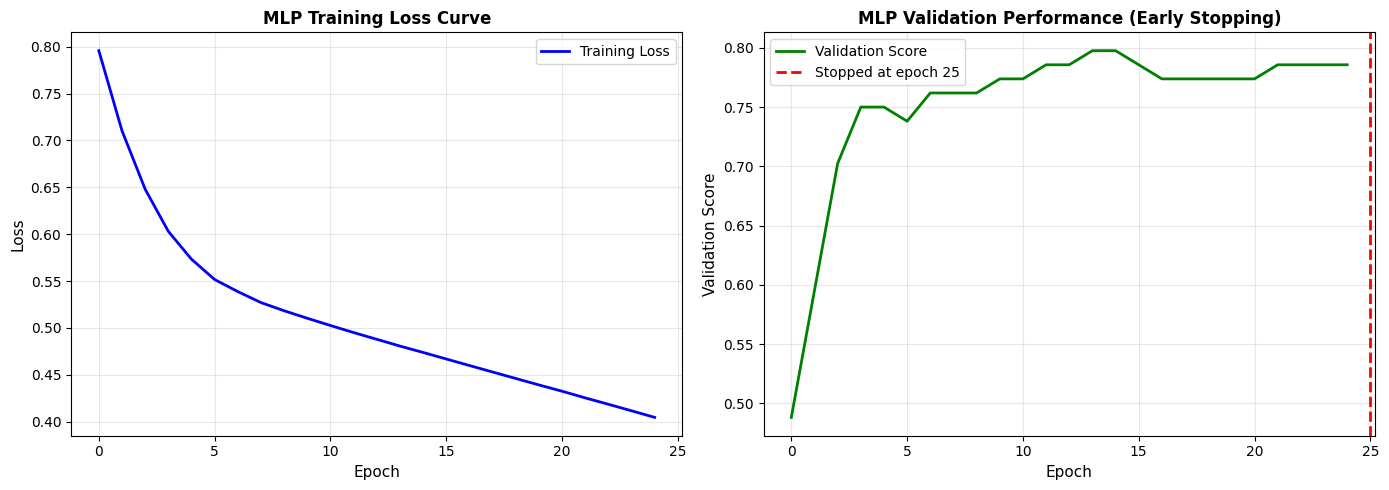

MLP stopped training at epoch 25 (early stopping triggered)
Final training loss: 0.4045
Best validation score: 0.7976


In [101]:
# MLP training vs validation performance
# This shows whether early stopping worked correctly and if the model converged
best_mlp_pipeline = best_pipelines["mlp"]
best_mlp = best_mlp_pipeline.named_steps["clf"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Training loss over epochs
ax1.plot(best_mlp.loss_curve_, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Loss", fontsize=11)
ax1.set_title("MLP Training Loss Curve", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot: Validation score over epochs
ax2.plot(best_mlp.validation_scores_, 'g-', linewidth=2, label='Validation Score')
ax2.axvline(x=best_mlp.n_iter_, color='r', linestyle='--', linewidth=2, label=f'Stopped at epoch {best_mlp.n_iter_}')
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Validation Score", fontsize=11)
ax2.set_title("MLP Validation Performance (Early Stopping)", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"MLP stopped training at epoch {best_mlp.n_iter_} (early stopping triggered)")
print(f"Final training loss: {best_mlp.loss_curve_[-1]:.4f}")
print(f"Best validation score: {max(best_mlp.validation_scores_):.4f}")


### Random Forrest Performance Breakdown

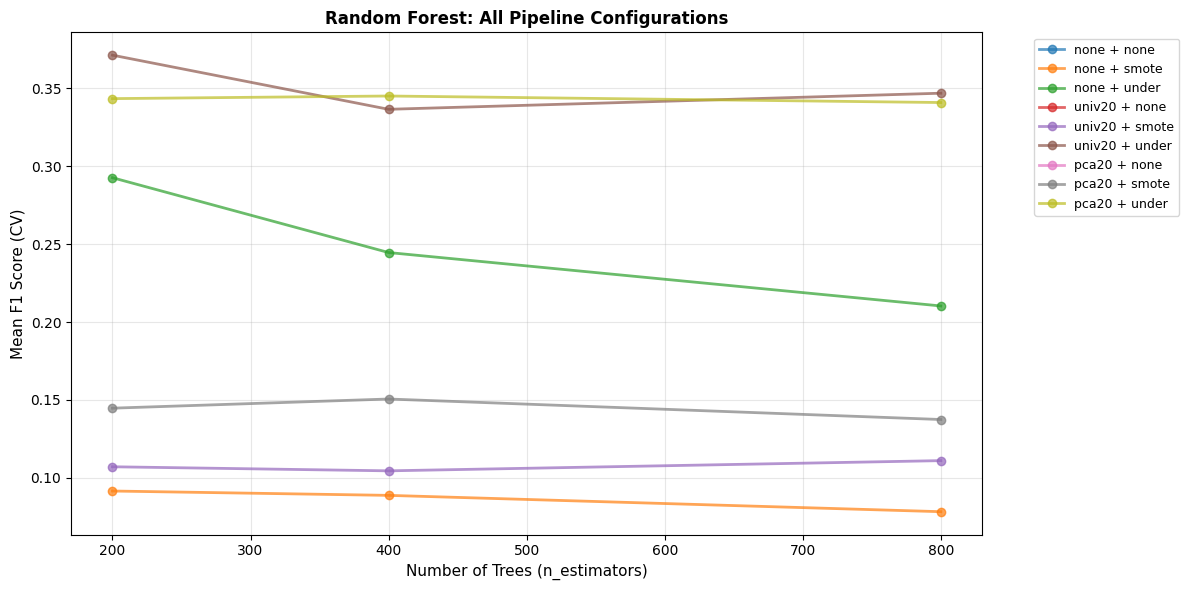


Top 5 RF configurations:
        config  param_clf__n_estimators  mean_test_score
univ20 + under                      200         0.371303
univ20 + under                      800         0.346885
 pca20 + under                      400         0.345090
 pca20 + under                      200         0.343404
 pca20 + under                      800         0.340900


In [102]:
# Random Forest: Performance breakdown by pipeline configuration
rf_cv = pd.DataFrame(search_results["rf"].cv_results_)

# Extract readable parameter names using the infer_step_name function
rf_cv['reducer'] = rf_cv['param_reducer'].apply(lambda x: infer_step_name(x, 'reducer'))
rf_cv['sampler'] = rf_cv['param_sampler'].apply(lambda x: infer_step_name(x, 'sampler'))

# Create configuration labels
rf_cv['config'] = rf_cv['reducer'] + ' + ' + rf_cv['sampler']

# Plot all configurations
plt.figure(figsize=(12, 6))

for config in rf_cv['config'].unique():
    subset = rf_cv[rf_cv['config'] == config].sort_values('param_clf__n_estimators')
    plt.plot(subset['param_clf__n_estimators'], subset['mean_test_score'], 
             'o-', linewidth=2, markersize=6, label=config, alpha=0.7)

plt.xlabel("Number of Trees (n_estimators)", fontsize=11)
plt.ylabel("Mean F1 Score (CV)", fontsize=11)
plt.title("Random Forest: All Pipeline Configurations", fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 RF configurations:")
print(rf_cv[['config', 'param_clf__n_estimators', 'mean_test_score']].nlargest(5, 'mean_test_score').to_string(index=False))


## Model Evaluation

### Helper Functions - Model Evaluation

In [103]:
def evaluate_pipeline(pipe, X, y, name="Model", threshold=0.5):
    """
    Evaluate a fitted pipeline on (X, y) with comprehensive metrics.
    
    Returns both threshold-dependent metrics (F1, F2, Precision, Recall) and
    threshold-independent metrics (ROC-AUC, PR-AUC).
    
    Note: I use threshold=0.5 here, threshold will be optimized later.
    """
    y_scores = pipe.predict_proba(X)[:, 1]
    y_pred = (y_scores >= threshold).astype(int)

    # Threshold-independent metrics (evaluate ranking quality)
    roc = roc_auc_score(y, y_scores)
    pr_auc = average_precision_score(y, y_scores)
    
    # Threshold-dependent metrics (evaluate at specific threshold)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2, zero_division=0)  # Weighs recall higher than precision
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"F2: {f2:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    
    return {
        "roc_auc": roc,
        "pr_auc": pr_auc,
        "f1": f1,
        "f2": f2,
        "precision": prec,
        "recall": rec,
    }

def evaluate_pipelines(
    best_pipelines: dict,
    X,
    y,
    groups,
    cv,
):
    """
    Cross-validate each tuned pipeline on (X, y, groups) using StratifiedGroupKFold.
    
    This provides a more robust estimate of model performance than a single train/test split.
    I use PR-AUC here because it's more stable across folds and doesn't require threshold selection.
    
    Returns:
        results_df: one row per classifier with mean/std for each metric.
    """
    metrics = {
        "accuracy": "accuracy",
        "f1": "f1",
        "roc_auc": "roc_auc",
        "pr_auc": "average_precision",
    }

    rows = []

    for clf_name, pipe in best_pipelines.items():
        print(f"Evaluating tuned pipeline for {clf_name}...")

        steps = pipe.named_steps
        sampler_obj = steps.get("sampler", None)
        scaler_obj = steps.get("scaler", None)
        reducer_obj = steps.get("reducer", None)

        sampler_name = infer_step_name(sampler_obj, kind="sampler")
        scaler_name = infer_step_name(scaler_obj,  kind="scaler")
        reducer_name = infer_step_name(reducer_obj, kind="reducer")

        # Suppress warnings from cross_validate (ConvergenceWarning, etc.)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_res = cross_validate(
                pipe,
                X,
                y,
                groups=groups,
                cv=cv,
                scoring=metrics,
                n_jobs=-1,
                return_train_score=False,
                verbose=0,
            )

        rows.append({
            "classifier": clf_name,
            "sampler": sampler_name,
            "scaler": scaler_name,
            "reducer": reducer_name,
            "accuracy_mean": cv_res["test_accuracy"].mean(),
            "accuracy_std": cv_res["test_accuracy"].std(),
            "f1_mean": cv_res["test_f1"].mean(),
            "f1_std": cv_res["test_f1"].std(),
            "roc_auc_mean": np.nanmean(cv_res["test_roc_auc"]),  # Use nanmean to handle folds with undefined ROC-AUC due to groups with single class
            "roc_auc_std": np.nanstd(cv_res["test_roc_auc"]),
            "pr_auc_mean": cv_res["test_pr_auc"].mean(),
            "pr_auc_std": cv_res["test_pr_auc"].std(),
        })

    results_df = pd.DataFrame(rows)
    return results_df

### Cross-Validation Results

In [104]:
results_df = evaluate_pipelines(
    best_pipelines=best_pipelines,
    X=X_train,
    y=y_train,
    groups=groups_train,
    cv=cv,
)
results_df

Evaluating tuned pipeline for rf...
Evaluating tuned pipeline for mlp...
Evaluating tuned pipeline for mlp...


,classifier,sampler,scaler,reducer,accuracy_mean,accuracy_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,rf,under,none,univ20,0.582196,0.108996,0.371303,0.242810,0.666869,0.140044,0.568753,0.317670
1,mlp,under,standard,pca20,0.672066,0.220265,0.561565,0.269632,0.642475,0.122452,0.539928,0.319049


### Performance Comparison

In [105]:
# Display cross-validation results sorted by F1
print("=" * 80)
print("CROSS-VALIDATION RESULTS (Training Set)")
print("=" * 80)
print("\nResults sorted by F1 Score")
print("-" * 80)
results_df_sorted_f1 = results_df.sort_values(
    by=["f1_mean"], ascending=False
).reset_index(drop=True)

display(results_df_sorted_f1.head(20))

best_f1 = results_df_sorted_f1.iloc[0]
print("\nBest configuration by F1 (CV):")
print("- sampler:", best_f1["sampler"])
print("- scaler:", best_f1["scaler"])
print("- reducer:", best_f1["reducer"])
print("- classifier:", best_f1["classifier"])
print()
print("CV Scores (mean +/- std over folds):")
for metric in ["accuracy", "f1", "roc_auc", "pr_auc"]:
    print(f"{metric:8s}: {best_f1[f'{metric}_mean']:.4f} +/- {best_f1[f'{metric}_std']:.4f}")

# Display results sorted by PR-AUC
print("\n" + "-" * 80)
print("Results sorted by PR-AUC")
print("-" * 80)
results_df_sorted_pr = results_df.sort_values(
    by=["pr_auc_mean"], ascending=False
).reset_index(drop=True)

display(results_df_sorted_pr.head(20))

best_pr = results_df_sorted_pr.iloc[0]
print("\nBest configuration by PR-AUC (CV):")
print("- sampler:", best_pr["sampler"])
print("- scaler:", best_pr["scaler"])
print("- reducer:", best_pr["reducer"])
print("- classifier:", best_pr["classifier"])
print()
print("CV Scores (mean +/- std over folds):")
for metric in ["accuracy", "f1", "roc_auc", "pr_auc"]:
    print(f"{metric:8s}: {best_pr[f'{metric}_mean']:.4f} +/- {best_pr[f'{metric}_std']:.4f}")

# Compare if different
if best_f1["classifier"] != best_pr["classifier"] or \
   best_f1["sampler"] != best_pr["sampler"] or \
   best_f1["scaler"] != best_pr["scaler"] or \
   best_f1["reducer"] != best_pr["reducer"]:
    print("NOTE: Best model differs between F1 and PR-AUC optimization!")

CROSS-VALIDATION RESULTS (Training Set)

Results sorted by F1 Score
--------------------------------------------------------------------------------


,classifier,sampler,scaler,reducer,accuracy_mean,accuracy_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,mlp,under,standard,pca20,0.672066,0.220265,0.561565,0.269632,0.642475,0.122452,0.539928,0.319049
1,rf,under,none,univ20,0.582196,0.108996,0.371303,0.242810,0.666869,0.140044,0.568753,0.317670



Best configuration by F1 (CV):
- sampler: under
- scaler: standard
- reducer: pca20
- classifier: mlp

CV Scores (mean +/- std over folds):
accuracy: 0.6721 +/- 0.2203
f1      : 0.5616 +/- 0.2696
roc_auc : 0.6425 +/- 0.1225
pr_auc  : 0.5399 +/- 0.3190

--------------------------------------------------------------------------------
Results sorted by PR-AUC
--------------------------------------------------------------------------------


,classifier,sampler,scaler,reducer,accuracy_mean,accuracy_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,rf,under,none,univ20,0.582196,0.108996,0.371303,0.242810,0.666869,0.140044,0.568753,0.317670
1,mlp,under,standard,pca20,0.672066,0.220265,0.561565,0.269632,0.642475,0.122452,0.539928,0.319049



Best configuration by PR-AUC (CV):
- sampler: under
- scaler: none
- reducer: univ20
- classifier: rf

CV Scores (mean +/- std over folds):
accuracy: 0.5822 +/- 0.1090
f1      : 0.3713 +/- 0.2428
roc_auc : 0.6669 +/- 0.1400
pr_auc  : 0.5688 +/- 0.3177
NOTE: Best model differs between F1 and PR-AUC optimization!


### Test Set Evaluation

In [106]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Evaluate best models on test set
print("=" * 80)
print("BEST MODELS: TEST SET EVALUATION")
print("=" * 80)
print("\nEvaluating best CV configurations on test set")
print("(Using models already trained by GridSearchCV - no retraining)\n")

best_rf_pipeline = best_pipelines['rf']
best_mlp_pipeline = best_pipelines['mlp']

# Get their configurations from search results
rf_search = search_results['rf']
mlp_search = search_results['mlp']

all_test_results = {}

print("\n" + "=" * 80)
print("RANDOM FOREST: Best Configuration")
print("=" * 80)

# Evaluate RF on test set
y_scores_rf = best_rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf = (y_scores_rf >= 0.5).astype(int)

test_f1_rf = f1_score(y_test, y_pred_rf)
test_pr_auc_rf = average_precision_score(y_test, y_scores_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_scores_rf)

rf_steps = best_rf_pipeline.named_steps
rf_sampler = infer_step_name(rf_steps.get('sampler'), 'sampler')
rf_reducer = infer_step_name(rf_steps.get('reducer'), 'reducer')

all_test_results['rf'] = {
    'model': 'RF',
    'cv_f1_mean': rf_search.best_score_,
    'test_f1': test_f1_rf,
    'test_pr_auc': test_pr_auc_rf,
    'test_roc_auc': test_roc_auc_rf,
    'sampler': rf_sampler,
    'reducer': rf_reducer,
    'pipeline': best_rf_pipeline
}

print(f"\nRF: CV F1={rf_search.best_score_:.4f} Test F1={test_f1_rf:.4f} (PR-AUC={test_pr_auc_rf:.4f})")
print(f"Config: {rf_reducer} + {rf_sampler}")

print("\n" + "=" * 80)
print("MLP: Best Configuration")
print("=" * 80)

# Evaluate MLP on test set
y_scores_mlp = best_mlp_pipeline.predict_proba(X_test)[:, 1]
y_pred_mlp = (y_scores_mlp >= 0.5).astype(int)

test_f1_mlp = f1_score(y_test, y_pred_mlp)
test_pr_auc_mlp = average_precision_score(y_test, y_scores_mlp)
test_roc_auc_mlp = roc_auc_score(y_test, y_scores_mlp)

mlp_steps = best_mlp_pipeline.named_steps
mlp_sampler = infer_step_name(mlp_steps.get('sampler'), 'sampler')
mlp_reducer = infer_step_name(mlp_steps.get('reducer'), 'reducer')

all_test_results['mlp'] = {
    'model': 'MLP',
    'cv_f1_mean': mlp_search.best_score_,
    'test_f1': test_f1_mlp,
    'test_pr_auc': test_pr_auc_mlp,
    'test_roc_auc': test_roc_auc_mlp,
    'sampler': mlp_sampler,
    'reducer': mlp_reducer,
    'pipeline': best_mlp_pipeline
}

print(f"\nMLP: CV F1={mlp_search.best_score_:.4f}   Test F1={test_f1_mlp:.4f} (PR-AUC={test_pr_auc_mlp:.4f})")
print(f"  Config: {mlp_reducer} + {mlp_sampler}")

# Create comparison dataframe
comparison_df = pd.DataFrame(all_test_results).T
comparison_df = comparison_df.sort_values('test_f1', ascending=False)

print("\n\n" + "=" * 80)
print("TEST SET COMPARISON")
print("=" * 80)
display(comparison_df[['model', 'cv_f1_mean', 'test_f1', 'test_pr_auc', 'test_roc_auc', 'sampler', 'reducer']])

print("\n" + "=" * 80)
print("SELECTED MODELS FOR THRESHOLD OPTIMIZATION")
print("=" * 80)
print(f"\nBest RF (GridSearchCV):")
print(f"- CV F1: {rf_search.best_score_:.4f}")
print(f"- Test F1: {test_f1_rf:.4f}")
print(f"- Config: {rf_reducer} + {rf_sampler}")

print(f"\nBest MLP (GridSearchCV):")
print(f"- CV F1: {mlp_search.best_score_:.4f}")
print(f"- Test F1: {test_f1_mlp:.4f}")
print(f"- Config: {mlp_reducer} + {mlp_sampler}")



BEST MODELS: TEST SET EVALUATION

Evaluating best CV configurations on test set
(Using models already trained by GridSearchCV - no retraining)


RANDOM FOREST: Best Configuration

RF: CV F1=0.3713 Test F1=0.2418 (PR-AUC=0.2985)
Config: univ20 + under

MLP: Best Configuration

MLP: CV F1=0.5616   Test F1=0.2226 (PR-AUC=0.1375)
  Config: pca20 + under


TEST SET COMPARISON


,model,cv_f1_mean,test_f1,test_pr_auc,test_roc_auc,sampler,reducer
rf,RF,0.371303,0.241803,0.298507,0.657606,under,univ20
mlp,MLP,0.561565,0.222615,0.137499,0.588113,under,pca20



SELECTED MODELS FOR THRESHOLD OPTIMIZATION

Best RF (GridSearchCV):
- CV F1: 0.3713
- Test F1: 0.2418
- Config: univ20 + under

Best MLP (GridSearchCV):
- CV F1: 0.5616
- Test F1: 0.2226
- Config: pca20 + under


### Confusion Matrices


CONFUSION MATRICES (Test Set, Default Threshold = 0.5)


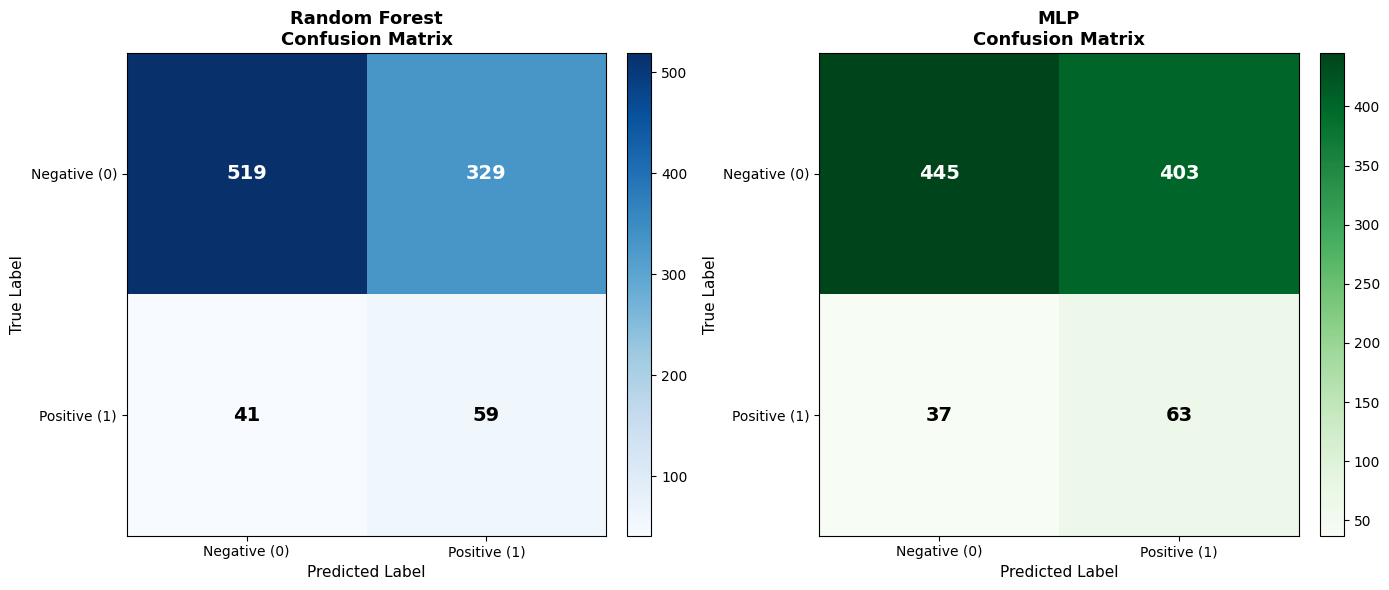


RF Confusion Matrix Analysis:
True Negatives:   519 | False Positives:  329
False Negatives:   41 | True Positives:    59

MLP Confusion Matrix Analysis:
True Negatives:   445 | False Positives:  403
False Negatives:   37 | True Positives:    63


In [107]:
# Display confusion matrices for both models
print("\n" + "=" * 80)
print("CONFUSION MATRICES (Test Set, Default Threshold = 0.5)")
print("=" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


# RF Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
im1 = ax1.imshow(cm_rf, cmap='Blues', aspect='auto')
ax1.set_title('Random Forest\nConfusion Matrix', fontsize=13, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=11)
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Negative (0)', 'Positive (1)'])
ax1.set_yticklabels(['Negative (0)', 'Positive (1)'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax1.text(j, i, f'{cm_rf[i, j]}',
                       ha="center", va="center", 
                       color="white" if cm_rf[i, j] > cm_rf.max()/2 else "black",
                       fontsize=14, fontweight='bold')

plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
im2 = ax2.imshow(cm_mlp, cmap='Greens', aspect='auto')
ax2.set_title('MLP\nConfusion Matrix', fontsize=13, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=11)
ax2.set_ylabel('True Label', fontsize=11)
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Negative (0)', 'Positive (1)'])
ax2.set_yticklabels(['Negative (0)', 'Positive (1)'])

for i in range(2):
    for j in range(2):
        text = ax2.text(j, i, f'{cm_mlp[i, j]}',
                       ha="center", va="center",
                       color="white" if cm_mlp[i, j] > cm_mlp.max()/2 else "black",
                       fontsize=14, fontweight='bold')

plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"\nRF Confusion Matrix Analysis:")
print(f"True Negatives:  {cm_rf[0, 0]:4d} | False Positives: {cm_rf[0, 1]:4d}")
print(f"False Negatives: {cm_rf[1, 0]:4d} | True Positives:  {cm_rf[1, 1]:4d}")

print(f"\nMLP Confusion Matrix Analysis:")
print(f"True Negatives:  {cm_mlp[0, 0]:4d} | False Positives: {cm_mlp[0, 1]:4d}")
print(f"False Negatives: {cm_mlp[1, 0]:4d} | True Positives:  {cm_mlp[1, 1]:4d}")

# Store model names and pipelines for threshold optimization
best_rf_name = 'rf'
best_mlp_name = 'mlp'
best_pipelines_test = best_pipelines

### Threshold Optimization

In [108]:
def find_optimal_threshold(pipeline, X, y, groups, cv, metric='f1'):
    """
    Find optimal classification threshold using cross-validation.
    
    For each CV fold:
    - Get probability scores on validation set
    - Calculate precision-recall curve
    - Find threshold that maximizes chosen metric (F1, F2, etc.)
    
    Returns the median optimal threshold across all folds.
    """
    optimal_thresholds = []
    
    for train_idx, val_idx in cv.split(X, y, groups):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Clone and fit pipeline on this fold
        from sklearn.base import clone
        pipe_fold = clone(pipeline)
        pipe_fold.fit(X_train_fold, y_train_fold)
        
        # Get probability scores on validation fold
        y_scores = pipe_fold.predict_proba(X_val_fold)[:, 1]
        
        # Calculate precision and recall for all possible thresholds
        precision, recall, thresholds = precision_recall_curve(y_val_fold, y_scores)
        
        # Calculate chosen metric for each threshold
        if metric == 'f1':
            # F1 = 2 * (precision * recall) / (precision + recall)
            scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
        elif metric == 'f2':
            # F2 weighs recall higher than precision
            beta = 2
            scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-10)
        else:
            scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
        
        # Find threshold that maximizes the metric
        best_idx = np.argmax(scores)
        optimal_thresholds.append(thresholds[best_idx])
    
    # Return median threshold across folds (more robust than mean)
    return np.median(optimal_thresholds)


# Optimize thresholds for test-validated best RF and MLP
print("=" * 80)
print("THRESHOLD OPTIMIZATION (Training Set with CV)")
print("=" * 80)
optimal_thresholds = {}

for model_name in ['rf', 'mlp']:
    print(f"Optimizing threshold for {model_name.upper()}...")
    
    opt_threshold = find_optimal_threshold(
        pipeline=best_pipelines_test[model_name],
        X=X_train,
        y=y_train,
        groups=groups_train,
        cv=cv,
        metric='f1'
    )
    
    optimal_thresholds[model_name] = opt_threshold
    print(f"Optimal threshold: {opt_threshold:.4f} (default: 0.5000)")
    print(f"(Found by maximizing F1 across CV validation folds)\n")

THRESHOLD OPTIMIZATION (Training Set with CV)
Optimizing threshold for RF...
Optimal threshold: 0.4350 (default: 0.5000)
(Found by maximizing F1 across CV validation folds)

Optimizing threshold for MLP...
Optimal threshold: 0.4350 (default: 0.5000)
(Found by maximizing F1 across CV validation folds)

Optimizing threshold for MLP...
Optimal threshold: 0.5044 (default: 0.5000)
(Found by maximizing F1 across CV validation folds)

Optimal threshold: 0.5044 (default: 0.5000)
(Found by maximizing F1 across CV validation folds)



### Precision-Recall Curves


PRECISION-RECALL CURVES (TEST SET)


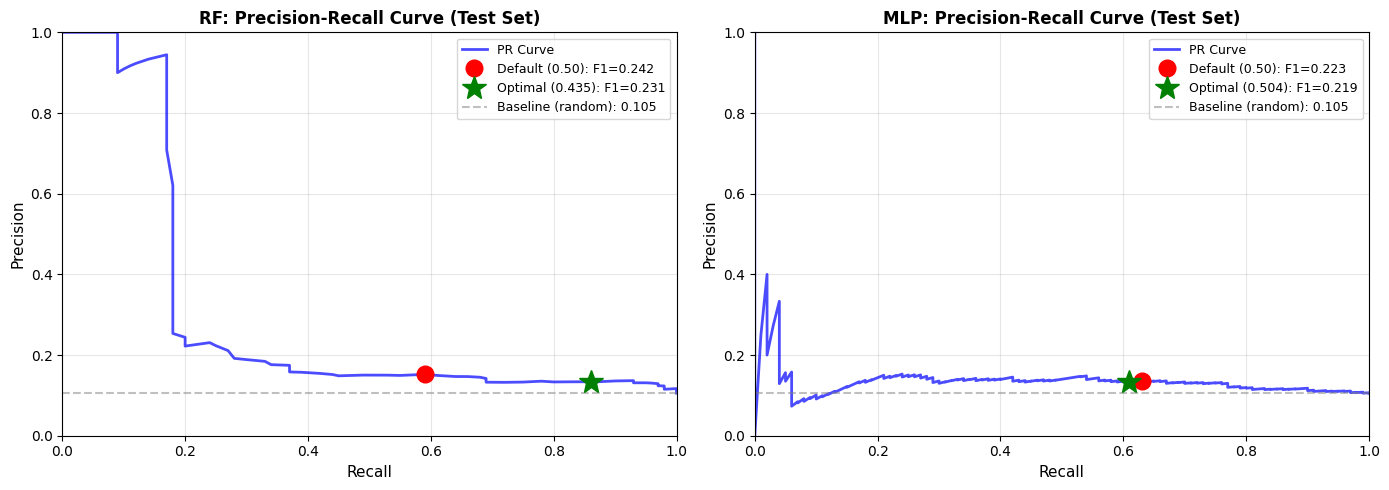


INTERPRETATION:
Green star (*) = Optimal threshold found via CV on training set
Red circle (o) = Default threshold (0.5)

These F1 scores reflect test set performance (true generalization).
Compare to CV scores earlier to assess consistency.


In [109]:
# Visualize precision-recall curves on test set with optimal thresholds
print("\n" + "=" * 80)
print("PRECISION-RECALL CURVES (TEST SET)")
print("=" * 80)

n_models = len(optimal_thresholds)
fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 5))

if n_models == 1:
    axes = [axes]

for idx, (clf_name, opt_thresh) in enumerate(optimal_thresholds.items()):
    ax = axes[idx]
    
    # Get probability scores on TEST set
    y_scores = best_pipelines_test[clf_name].predict_proba(X_test)[:, 1]
    
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    # Find points corresponding to default and optimal thresholds
    default_idx = np.argmin(np.abs(thresholds - 0.5))
    optimal_idx = np.argmin(np.abs(thresholds - opt_thresh))
    
    # Plot PR curve
    ax.plot(recall, precision, 'b-', linewidth=2, label='PR Curve', alpha=0.7)
    
    # Mark default threshold point
    ax.plot(recall[default_idx], precision[default_idx], 'ro', markersize=12, 
            label=f'Default (0.50): F1={f1_scores[default_idx]:.3f}', zorder=5)
    
    # Mark optimal threshold point
    ax.plot(recall[optimal_idx], precision[optimal_idx], 'g*', markersize=18, 
            label=f'Optimal ({opt_thresh:.3f}): F1={f1_scores[optimal_idx]:.3f}', zorder=5)
    
    # Baseline (random classifier)
    baseline = y_test.sum() / len(y_test)
    ax.axhline(y=baseline, color='gray', linestyle='--', linewidth=1.5, 
               label=f'Baseline (random): {baseline:.3f}', alpha=0.5)
    
    ax.set_xlabel("Recall", fontsize=11)
    ax.set_ylabel("Precision", fontsize=11)
    ax.set_title(f"{clf_name.upper()}: Precision-Recall Curve (Test Set)", fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("Green star (*) = Optimal threshold found via CV on training set")
print("Red circle (o) = Default threshold (0.5)")
print("\nThese F1 scores reflect test set performance (true generalization).")
print("Compare to CV scores earlier to assess consistency.")


### Final Evaluation & Recommendation

In [110]:
# Test set evaluation with both default and optimized thresholds
print("\n\n" + "=" * 80)
print("FINAL TEST SET EVALUATION")
print("=" * 80)
print("\nComparing performance with default (0.5) vs optimized thresholds")
print("This shows real-world performance on unseen data.\n")

test_results_default = {}
test_results_optimized = {}

# Evaluate both RF and MLP with both thresholds
for clf_name in ['rf', 'mlp']:
    pipeline = best_pipelines_test[clf_name]
    
    print("\n" + "=" * 80)
    print(f"Model: {clf_name.upper()}")
    print("=" * 80)
    
    # Evaluate with default threshold
    print(f"\n[DEFAULT THRESHOLD = 0.5]")
    test_results_default[clf_name] = evaluate_pipeline(
        pipeline, 
        X_test, 
        y_test, 
        name=f"{clf_name.upper()}",
        threshold=0.5
    )
    
    # Evaluate with optimized threshold
    opt_thresh = optimal_thresholds[clf_name]
    print(f"\n[OPTIMIZED THRESHOLD = {opt_thresh:.4f}]")
    test_results_optimized[clf_name] = evaluate_pipeline(
        pipeline, 
        X_test, 
        y_test, 
        name=f"{clf_name.upper()}",
        threshold=opt_thresh
    )
    
    # Calculate improvement
    f1_default = test_results_default[clf_name]['f1']
    f1_optimized = test_results_optimized[clf_name]['f1']
    improvement = f1_optimized - f1_default
    
    print(f"\nF1 Improvement: {improvement:+.4f} ({f1_default:.4f}   {f1_optimized:.4f})")

# Summary tables
print("\n\n" + "=" * 80)
print("TEST SET SUMMARY: DEFAULT THRESHOLD (0.5)")
print("=" * 80)
test_summary_default = pd.DataFrame(test_results_default).T
test_summary_default = test_summary_default.sort_values(by="pr_auc", ascending=False)
display(test_summary_default)

print("\n" + "=" * 80)
print("TEST SET SUMMARY: OPTIMIZED THRESHOLDS")
print("=" * 80)
test_summary_optimized = pd.DataFrame(test_results_optimized).T
test_summary_optimized = test_summary_optimized.sort_values(by="f1", ascending=False)
display(test_summary_optimized)

# Comparison table
print("\n" + "=" * 80)
print("THRESHOLD OPTIMIZATION IMPACT")
print("=" * 80)
comparison_data = []
for clf_name in ['rf', 'mlp']:
    f1_gain = test_results_optimized[clf_name]['f1'] - test_results_default[clf_name]['f1']
    # If optimization makes things worse, keep default threshold and results
    if f1_gain < 0:
        use_threshold = 0.5
        use_results = test_results_default[clf_name]
        note = "Using default (optimized worse)"
    else:
        use_threshold = optimal_thresholds[clf_name]
        use_results = test_results_optimized[clf_name]
        note = "Using optimized"
    
    comparison_data.append({
        'Model': clf_name.upper(),
        'Threshold_Default': 0.5,
        'F1_default': test_results_default[clf_name]['f1'],
        'Threshold_Optimized': optimal_thresholds[clf_name],
        'F1_optimized': test_results_optimized[clf_name]['f1'],
        'F1_gain': f1_gain,
        'Selected_Threshold': use_threshold,
        'Selected_F1': use_results['f1'],
        'PR_AUC': use_results['pr_auc'],
        'Precision': use_results['precision'],
        'Recall': use_results['recall'],
        'Note': note
    })
comparison_df_final = pd.DataFrame(comparison_data)
comparison_df_final = comparison_df_final.sort_values(by='Selected_F1', ascending=False)
display(comparison_df_final)

# Store the selected thresholds and results for final recommendation
selected_thresholds = {}
selected_results = {}
for clf_name in ['rf', 'mlp']:
    f1_gain = test_results_optimized[clf_name]['f1'] - test_results_default[clf_name]['f1']
    if f1_gain < 0:
        selected_thresholds[clf_name] = 0.5
        selected_results[clf_name] = test_results_default[clf_name]
        print(f"\n{clf_name.upper()}: Optimized threshold ({optimal_thresholds[clf_name]:.4f}) performed WORSE than default.")
        print(f"Using default threshold (0.5) with F1={test_results_default[clf_name]['f1']:.4f}")
    else:
        selected_thresholds[clf_name] = optimal_thresholds[clf_name]
        selected_results[clf_name] = test_results_optimized[clf_name]
        print(f"\n{clf_name.upper()}: Optimized threshold improved performance.")
        print(f"Using optimized threshold ({optimal_thresholds[clf_name]:.4f}) with F1={test_results_optimized[clf_name]['f1']:.4f}")

# Final recommendation with both best models shown
print("\n" + "=" * 80)
print("FINAL RECOMMENDATION")
print("=" * 80)

# Use selected results (which use default threshold when optimized is worse)
rf_results = selected_results['rf']
mlp_results = selected_results['mlp']

print("\n" + "─" * 80)
print("BEST RANDOM FOREST MODEL")
print("─" * 80)
print(f"Configuration: {all_test_results['rf']['reducer']} + {all_test_results['rf']['sampler']}")
print(f"Operating threshold: {selected_thresholds['rf']:.4f}")
print(f"- F1 Score: {rf_results['f1']:.4f}")
print(f"- PR-AUC: {rf_results['pr_auc']:.4f}")
print(f"- ROC-AUC: {rf_results['roc_auc']:.4f}")
print(f"- Precision: {rf_results['precision']:.4f}")
print(f"- Recall: {rf_results['recall']:.4f}")

print("\n" + "─" * 80)
print("BEST MLP MODEL")
print("─" * 80)
print(f"Configuration: {all_test_results['mlp']['reducer']} + {all_test_results['mlp']['sampler']}")
print(f"Operating threshold: {selected_thresholds['mlp']:.4f}")
print(f"- F1 Score: {mlp_results['f1']:.4f}")
print(f"- PR-AUC: {mlp_results['pr_auc']:.4f}")
print(f"- ROC-AUC: {mlp_results['roc_auc']:.4f}")
print(f"- Precision: {mlp_results['precision']:.4f}")
print(f"- Recall: {mlp_results['recall']:.4f}")

# Determine overall best based on selected F1 scores
if rf_results['f1'] >= mlp_results['f1']:
    best_overall = 'rf'
    winner_results = rf_results
    winner_config = all_test_results['rf']
else:
    best_overall = 'mlp'
    winner_results = mlp_results
    winner_config = all_test_results['mlp']

print("\n" + "─" * 80)
print("OVERALL RECOMMENDATION")
print("─" * 80)
print(f"Use: {best_overall.upper()} ({winner_config['reducer']} + {winner_config['sampler']})")
print(f"Threshold: {selected_thresholds[best_overall]:.4f}")
print(f"Expected Performance:")
print(f"- F1 Score: {winner_results['f1']:.4f}")
print(f"- PR-AUC: {winner_results['pr_auc']:.4f}")
print(f"- Precision: {winner_results['precision']:.4f}")
print(f"- Recall: {winner_results['recall']:.4f}")



FINAL TEST SET EVALUATION

Comparing performance with default (0.5) vs optimized thresholds
This shows real-world performance on unseen data.


Model: RF

[DEFAULT THRESHOLD = 0.5]

=== RF ===
Threshold: 0.50
ROC-AUC: 0.6576
PR-AUC: 0.2985
F1: 0.2418
F2: 0.3744
Precision: 0.1521
Recall: 0.5900

[OPTIMIZED THRESHOLD = 0.4350]

=== RF ===
Threshold: 0.43
ROC-AUC: 0.6576
PR-AUC: 0.2985
F1: 0.2315
F2: 0.4123
Precision: 0.1337
Recall: 0.8600

F1 Improvement: -0.0103 (0.2418   0.2315)

Model: MLP

[DEFAULT THRESHOLD = 0.5]

=== MLP ===
Threshold: 0.50
ROC-AUC: 0.5881
PR-AUC: 0.1375
F1: 0.2226
F2: 0.3637
Precision: 0.1352
Recall: 0.6300

[OPTIMIZED THRESHOLD = 0.5044]

=== MLP ===
Threshold: 0.50
ROC-AUC: 0.5881
PR-AUC: 0.1375
F1: 0.2186
F2: 0.3555
Precision: 0.1332
Recall: 0.6100

F1 Improvement: -0.0040 (0.2226   0.2186)


TEST SET SUMMARY: DEFAULT THRESHOLD (0.5)


,roc_auc,pr_auc,f1,f2,precision,recall
rf,0.657606,0.298507,0.241803,0.374365,0.152062,0.59
mlp,0.588113,0.137499,0.222615,0.363741,0.135193,0.63



TEST SET SUMMARY: OPTIMIZED THRESHOLDS


,roc_auc,pr_auc,f1,f2,precision,recall
rf,0.657606,0.298507,0.231494,0.412272,0.133748,0.86
mlp,0.588113,0.137499,0.218638,0.355478,0.133188,0.61



THRESHOLD OPTIMIZATION IMPACT


,Model,Threshold_Default,F1_default,Threshold_Optimized,F1_optimized,F1_gain,Selected_Threshold,Selected_F1,PR_AUC,Precision,Recall,Note
0,RF,0.5,0.241803,0.435000,0.231494,-0.010309,0.5,0.241803,0.298507,0.152062,0.59,Using default (optimized worse)
1,MLP,0.5,0.222615,0.504359,0.218638,-0.003977,0.5,0.222615,0.137499,0.135193,0.63,Using default (optimized worse)



RF: Optimized threshold (0.4350) performed WORSE than default.
Using default threshold (0.5) with F1=0.2418

MLP: Optimized threshold (0.5044) performed WORSE than default.
Using default threshold (0.5) with F1=0.2226

FINAL RECOMMENDATION

────────────────────────────────────────────────────────────────────────────────
BEST RANDOM FOREST MODEL
────────────────────────────────────────────────────────────────────────────────
Configuration: univ20 + under
Operating threshold: 0.5000
- F1 Score: 0.2418
- PR-AUC: 0.2985
- ROC-AUC: 0.6576
- Precision: 0.1521
- Recall: 0.5900

────────────────────────────────────────────────────────────────────────────────
BEST MLP MODEL
────────────────────────────────────────────────────────────────────────────────
Configuration: pca20 + under
Operating threshold: 0.5000
- F1 Score: 0.2226
- PR-AUC: 0.1375
- ROC-AUC: 0.5881
- Precision: 0.1352
- Recall: 0.6300

────────────────────────────────────────────────────────────────────────────────
OVERALL RECOMM